https://gamma.app/docs/Deteccion-automatica-de-neumonia-en-radiografias-de-torax-2r73yc3bbf6eqe0

# 1. Instalar kagglehub

In [ ]:
# !pip install kagglehub

# 2. Descargar el dataset CheXpert desde Kaggle

In [ ]:
import kagglehub
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#path = kagglehub.dataset_download("ashery/chexpert")
#print("Dataset descargado en:", path)

# 3. Montar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 4. Definir la ruta destino en tu Drive

In [ ]:
destino = "/content/drive/MyDrive/Chexpert"

# Si ya existe una carpeta anterior, la borramos para no duplicar
#if os.path.exists(destino):
#    shutil.rmtree(destino)

# 5. Copiar dataset al Drive

In [ ]:
#shutil.copytree(path, destino)

#print("Dataset copiado en tu Google Drive:", destino)

# 6. Verificar contenido

In [ ]:
print("Archivos en Drive:", os.listdir(destino))

Archivos en Drive: ['valid', 'train', 'train.csv', 'valid.csv', 'modelo_pneumonia.h5']


# 7. Explorar el CSV

In [ ]:
# Ruta a tu Drive
train_csv = "/content/drive/MyDrive/Chexpert/train.csv"
valid_csv = "/content/drive/MyDrive/Chexpert/valid.csv"

# Cargar CSVs
df_train = pd.read_csv(train_csv)
df_valid = pd.read_csv(valid_csv)

# Mostrar información básica
print("Train shape:", df_train.shape)
print("Valid shape:", df_valid.shape)

print("\nPrimeras filas del train.csv:")
display(df_train.head())

print("\nPrimeras filas del valid.csv:")
display(df_valid.head())


Train shape: (223414, 19)
Valid shape: (234, 19)

Primeras filas del train.csv:


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN



Primeras filas del valid.csv:


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


De todo CheXpert vamos a quedarnos solo con la etiqueta de neumonía (Pneumonia), que es binaria.

1.0 → neumonía presente

0.0 → neumonía ausente

NaN o -1.0 → casos inciertos o faltantes (podemos tratarlos como 0 para simplificar).

In [ ]:
# Cargar el CSV
df = pd.read_csv("/content/drive/MyDrive/Chexpert/train.csv")

# Reemplazar valores inciertos (-1.0 o NaN) por 0
df["Pneumonia"] = df["Pneumonia"].replace(-1.0, 0).fillna(0)

# Calcular frecuencias absolutas y relativas
conteo = df["Pneumonia"].value_counts().sort_index()
porcentaje = df["Pneumonia"].value_counts(normalize=True).sort_index() * 100

# Crear tabla resumen
tabla = pd.DataFrame({
    "Clase": ["No Neumonía (0)", "Con Neumonía (1)"],
    "Cantidad": conteo.values,
    "Porcentaje (%)": porcentaje.values.round(2)
})

from IPython.display import display
display(tabla.style.set_properties(**{'text-align': 'center'})
                  .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}]))

,Clase,Cantidad,Porcentaje (%)
0,No Neumonía (0),217375,97.300000
1,Con Neumonía (1),6039,2.700000


/tmp/ipython-input-1711992940.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=resumen, x="Clase", y="Cantidad", palette="coolwarm")


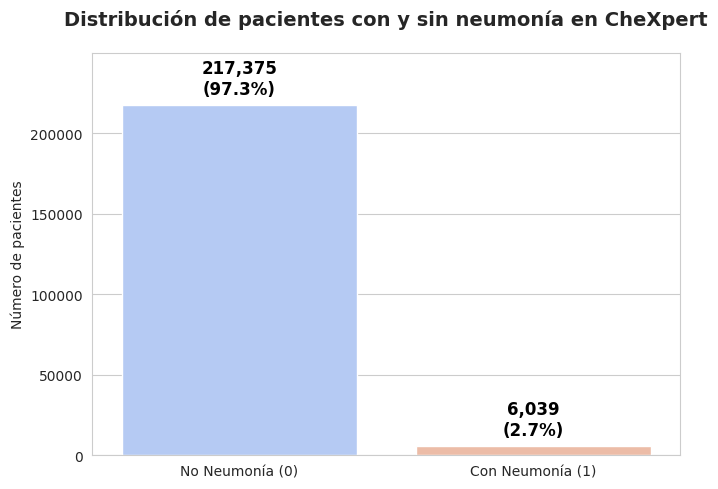

In [ ]:
# Preparar datos para seaborn
resumen = pd.DataFrame({
    "Clase": ["No Neumonía (0)", "Con Neumonía (1)"],
    "Cantidad": conteo.values,
    "Porcentaje": porcentaje.values
})

# Gráfica
plt.figure(figsize=(7,5))
sns.set_style("whitegrid")
ax = sns.barplot(data=resumen, x="Clase", y="Cantidad", palette="coolwarm")

# Aumentar límite del eje Y para dar espacio a los textos
ax.set_ylim(0, max(resumen["Cantidad"]) * 1.15)

# Añadir números y porcentajes encima de cada barra
for i, row in resumen.iterrows():
    ax.text(i, row["Cantidad"] + (0.02 * max(resumen["Cantidad"])),  # más espacio
            f'{int(row["Cantidad"]):,}\n({row["Porcentaje"]:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight="bold", color="black")

# Añadir título con padding extra
plt.title("Distribución de pacientes con y sin neumonía en CheXpert",
          fontsize=14, fontweight="bold", pad=20)

plt.xlabel("")
plt.ylabel("Número de pacientes")
plt.tight_layout()
plt.show()

#empezamos a validar el modelo con lo visto en clase

Chamo esto es para pasar las imagenes a un vector para que se puedan aplicar los metodos que queremos aun que no es muy efectivo pero es para aplicar los metodos ya que al profe no le importa si es muy perfecto el model

Okk

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# ============================================
# PASO 1: CREAR DATASET BALANCEADO
# ============================================
print("📊 Preparando dataset balanceado...")

# Separar por clase
no_pneumonia = df[df["Pneumonia"] == 0]
yes_pneumonia = df[df["Pneumonia"] == 1]

print(f"Disponibles SIN neumonía: {len(no_pneumonia)}")
print(f"Disponibles CON neumonía: {len(yes_pneumonia)}")

# Tomar el mismo número de muestras de cada clase
n_samples = 500  #

no_pneumonia_sample = no_pneumonia.sample(n=min(n_samples, len(no_pneumonia)), random_state=42)
yes_pneumonia_sample = yes_pneumonia.sample(n=min(n_samples, len(yes_pneumonia)), random_state=42)

# Combinar y mezclar
df_balanced = pd.concat([no_pneumonia_sample, yes_pneumonia_sample])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✓ Dataset balanceado creado: {len(df_balanced)} imágenes")
print(f"Distribución:")
print(df_balanced["Pneumonia"].value_counts())

# ============================================
# 🔥 PASO CRÍTICO: LIMPIAR RUTAS
# ============================================
print("\n🔧 Limpiando rutas de imágenes...")

# Eliminar el prefijo problemático
df_balanced["Path"] = df_balanced["Path"].str.replace("CheXpert-v1.0-small/", "", regex=False)

print(f"✓ Rutas limpiadas")
print(f"Ejemplo de ruta: {df_balanced.iloc[0]['Path']}")

# ============================================
# PASO 2: CARGAR IMÁGENES
# ============================================
BASE_DIR = "/content/drive/MyDrive/Chexpert/"

X = []
y = []
loaded_indices = []
failed_paths = []

print("\n🔄 Cargando imágenes...")

for index, row in df_balanced.iterrows():
    img_path = os.path.join(BASE_DIR, row["Path"])

    if not os.path.exists(img_path):
        failed_paths.append(img_path)
        continue

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        failed_paths.append(img_path)
        continue

    img = cv2.resize(img, (128, 128))
    X.append(img)
    y.append(row["Pneumonia"])
    loaded_indices.append(index)

X = np.array(X)
y = np.array(y)

print(f"\n✓ Imágenes cargadas exitosamente: {len(X)}")
print(f"✗ Imágenes que fallaron: {len(failed_paths)}")

# Verificar balance final
if len(X) > 0:
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n📊 Balance final del dataset cargado:")
    for label, count in zip(unique, counts):
        label_name = "Sin neumonía" if label == 0 else "Con neumonía"
        percentage = (count / len(y)) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")
else:
    print("\n❌ ERROR: No se cargaron imágenes. Verifica las rutas.")

if len(failed_paths) > 0:
    print(f"\n⚠ Primeras 5 rutas que fallaron:")
    for path in failed_paths[:5]:
        print(f"  - {path}")

    # Verificar si el problema es la estructura de carpetas
    print("\n🔍 Diagnóstico:")
    test_path = failed_paths[0]
    print(f"Ruta completa que falló: {test_path}")

    # Verificar si la carpeta padre existe
    parent_dir = os.path.dirname(test_path)
    print(f"¿Existe la carpeta padre? {os.path.exists(parent_dir)}")

    if os.path.exists(parent_dir):
        print(f"Contenido de la carpeta: {os.listdir(parent_dir)[:5]}")

📊 Preparando dataset balanceado...
Disponibles SIN neumonía: 217375
Disponibles CON neumonía: 6039

✓ Dataset balanceado creado: 1000 imágenes
Distribución:
Pneumonia
1.0    500
0.0    500
Name: count, dtype: int64

🔧 Limpiando rutas de imágenes...
✓ Rutas limpiadas
Ejemplo de ruta: train/patient05388/study1/view2_lateral.jpg

🔄 Cargando imágenes...

✓ Imágenes cargadas exitosamente: 859
✗ Imágenes que fallaron: 141

📊 Balance final del dataset cargado:
  Sin neumonía: 432 (50.3%)
  Con neumonía: 427 (49.7%)

⚠ Primeras 5 rutas que fallaron:
  - /content/drive/MyDrive/Chexpert/train/patient00897/study1/view1_frontal.jpg
  - /content/drive/MyDrive/Chexpert/train/patient05026/study1/view2_lateral.jpg
  - /content/drive/MyDrive/Chexpert/train/patient53599/study1/view1_frontal.jpg
  - /content/drive/MyDrive/Chexpert/train/patient57117/study1/view1_frontal.jpg
  - /content/drive/MyDrive/Chexpert/train/patient19008/study1/view1_frontal.jpg

🔍 Diagnóstico:
Ruta completa que falló: /content/dr

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 1)),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,229,121 (16.13 MB)

 Trainable params: 4,228,353 (16.13 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=15,
    batch_size=32
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.4970 - loss: 0.9975 - precision: 0.5052 - recall: 0.4771 - val_accuracy: 0.5407 - val_loss: 1.1770 - val_precision: 0.6500 - val_recall: 0.1529
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5760 - loss: 0.7450 - precision: 0.5590 - recall: 0.5598 - val_accuracy: 0.5058 - val_loss: 1.3187 - val_precision: 0.5000 - val_recall: 0.0353
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6021 - loss: 0.6860 - precision: 0.5914 - recall: 0.6204 - val_accuracy: 0.5116 - val_loss: 1.4863 - val_precision: 0.5385 - val_recall: 0.0824
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5853 - loss: 0.7341 - precision: 0.5638 - recall: 0.6013 - val_accuracy: 0.5174 - val_loss: 1.5771 - val_precision: 0.6000 - val_recall: 0.0706
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6667 - loss: 0.6405 - precision: 0.6570 - recall: 0.6656 - val_accuracy: 0.5349 - val_loss: 0.9574 - v

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies, precisions, recalls, f1s = [], [], [], []

for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

      # tu arquitectura keras.Sequential()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

print(f"Accuracy promedio: {np.mean(accuracies):.3f}")
print(f"Precision promedio: {np.mean(precisions):.3f}")
print(f"Recall promedio: {np.mean(recalls):.3f}")
print(f"F1 promedio: {np.mean(f1s):.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Accuracy promedio: 0.867
Precision promedio: 0.888
Recall promedio: 0.841
F1 promedio: 0.862


In [ ]:
results = model.evaluate(X_valid, y_valid, verbose=1)

print("\nResultados finales en Validación:")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9690 - loss: 0.1141 - precision: 1.0000 - recall: 0.9379 

Resultados finales en Validación:
Loss: 0.0933
Accuracy: 0.9767
Precision: 1.0000
Recall: 0.9529


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_prob = model.predict(X_valid)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convertir probabilidades a 0/1

print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_pred))

print("\nReporte Completo:")
print(classification_report(y_valid, y_pred))



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Matriz de Confusión:
[[87  0]
 [ 4 81]]

Reporte Completo:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        87
         1.0       1.00      0.95      0.98        85

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172



In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# ============================================
# PASO 1: CREAR DATASET BALANCEADO
# ============================================
print("📊 Preparando dataset balanceado...")

# Separar por clase
no_pneumonia = df[df["Pneumonia"] == 0]
yes_pneumonia = df[df["Pneumonia"] == 1]

print(f"Disponibles SIN neumonía: {len(no_pneumonia)}")
print(f"Disponibles CON neumonía: {len(yes_pneumonia)}")

# Tomar el mismo número de muestras de cada clase
n_samples = 500  #

no_pneumonia_sample = no_pneumonia.sample(n=min(n_samples, len(no_pneumonia)), random_state=42)
yes_pneumonia_sample = yes_pneumonia.sample(n=min(n_samples, len(yes_pneumonia)), random_state=42)

# Combinar y mezclar
df_balanced = pd.concat([no_pneumonia_sample, yes_pneumonia_sample])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✓ Dataset balanceado creado: {len(df_balanced)} imágenes")
print(f"Distribución:")
print(df_balanced["Pneumonia"].value_counts())

# ============================================
# 🔥 PASO CRÍTICO: LIMPIAR RUTAS
# ============================================
print("\n🔧 Limpiando rutas de imágenes...")

# Eliminar el prefijo problemático
df_balanced["Path"] = df_balanced["Path"].str.replace("CheXpert-v1.0-small/", "", regex=False)

print(f"✓ Rutas limpiadas")
print(f"Ejemplo de ruta: {df_balanced.iloc[0]['Path']}")

# ============================================
# PASO 2: CARGAR IMÁGENES
# ============================================
BASE_DIR = "/content/drive/MyDrive/Chexpert/"

X = []
y = []
loaded_indices = []
failed_paths = []

print("\n🔄 Cargando imágenes...")

for index, row in df_balanced.iterrows():
    img_path = os.path.join(BASE_DIR, row["Path"])

    if not os.path.exists(img_path):
        failed_paths.append(img_path)
        continue

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        failed_paths.append(img_path)
        continue

    img = cv2.resize(img, (128, 128))
    # Do NOT flatten the image here. Append the 2D image.
    X.append(img.reshape(-1))
    y.append(row["Pneumonia"])
    loaded_indices.append(index)

X = np.array(X)
y = np.array(y)

# Reshape X to add the channel dimension (1 for grayscale)
# The Keras model expects input shape (batch_size, height, width, channels)

X = X.reshape(X.shape[0], -1)
#X = X.reshape(X.shape[0], 128, 128, 1)

print(f"\n✓ Imágenes cargadas exitosamente: {len(X)}")
print(f"✗ Imágenes que fallaron: {len(failed_paths)}")

# Verificar balance final
if len(X) > 0:
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n📊 Balance final del dataset cargado:")
    for label, count in zip(unique, counts):
        label_name = "Sin neumonía" if label == 0 else "Con neumonía"
        percentage = (count / len(y)) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")
else:
    print("\n❌ ERROR: No se cargaron imágenes. Verifica las rutas.")

if len(failed_paths) > 0:
    print(f"\n⚠ Primeras 5 rutas que fallaron:")
    for path in failed_paths[:5]:
        print(f"  - {path}")

    # Verificar si el problema es la estructura de carpetas
    print("\n🔍 Diagnóstico:")
    test_path = failed_paths[0]
    print(f"Ruta completa que falló: {test_path}")

    # Verificar si la carpeta padre existe
    parent_dir = os.path.dirname(test_path)
    print(f"¿Existe la carpeta padre? {os.path.exists(parent_dir)}")

    if os.path.exists(parent_dir):
        print(f"Contenido de la carpeta: {os.listdir(parent_dir)[:5]}")

📊 Preparando dataset balanceado...
Disponibles SIN neumonía: 217374
Disponibles CON neumonía: 6039

✓ Dataset balanceado creado: 1000 imágenes
Distribución:
Pneumonia
1.0    500
0.0    500
Name: count, dtype: int64

🔧 Limpiando rutas de imágenes...
✓ Rutas limpiadas
Ejemplo de ruta: train/patient05388/study1/view2_lateral.jpg

🔄 Cargando imágenes...

✓ Imágenes cargadas exitosamente: 860
✗ Imágenes que fallaron: 140

📊 Balance final del dataset cargado:
  Sin neumonía: 433 (50.3%)
  Con neumonía: 427 (49.7%)

⚠ Primeras 5 rutas que fallaron:
  - /content/drive/MyDrive/Chexpert/train/patient00897/study1/view1_frontal.jpg
  - /content/drive/MyDrive/Chexpert/train/patient05026/study1/view2_lateral.jpg
  - /content/drive/MyDrive/Chexpert/train/patient53599/study1/view1_frontal.jpg
  - /content/drive/MyDrive/Chexpert/train/patient57117/study1/view1_frontal.jpg
  - /content/drive/MyDrive/Chexpert/train/patient19008/study1/view1_frontal.jpg

🔍 Diagnóstico:
Ruta completa que falló: /content/dr

kfold

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score
import numpy as np

# Asumiendo que ya tienes tu estimador `est`, y tus datos `X`, `y`
est = DecisionTreeClassifier(max_depth=2)
kf = KFold(10, shuffle=True)

# Accuracy
s = cross_val_score(est, X, y, cv=kf, scoring=make_scorer(accuracy_score))
print("Accuracy: %.3f (+/- %.5f)" % (np.mean(s), np.std(s)))

# Precision
p = cross_val_score(est, X, y, cv=kf, scoring=make_scorer(precision_score))
print("Precision: %.3f (+/- %.5f)" % (np.mean(p), np.std(p)))

# Recall
r = cross_val_score(est, X, y, cv=kf, scoring=make_scorer(recall_score))
print("Recall: %.3f (+/- %.5f)" % (np.mean(r), np.std(r)))

Accuracy: 0.520 (+/- 0.04352)
Precision: 0.525 (+/- 0.07117)
Recall: 0.744 (+/- 0.18895)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

est = RandomForestClassifier()

s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.521 (+/- 0.05169)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

est = SVC()

s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.527 (+/- 0.03208)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer

definimos el train test split con los datos que sacamos arriba

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Primero va el desicion tree o como se escriba Xd

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=20, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_valid)

# Métricas
accuracy1 = accuracy_score(y_valid, y_pred)
precision1 = precision_score(y_valid, y_pred, average='binary')
recall1 = recall_score(y_valid, y_pred, average='binary')

print("Accuracy:", accuracy1)
print("Precision:", precision1)
print("Recall:", recall1)

Accuracy: 0.5290697674418605
Precision: 0.5204081632653061
Recall: 0.6


ahora Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)

# Métricas
accuracy2 = accuracy_score(y_valid, y_pred)
precision2 = precision_score(y_valid, y_pred, average='binary')
recall2 = recall_score(y_valid, y_pred, average='binary')

print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)


Accuracy: 0.47674418604651164
Precision: 0.4657534246575342
Recall: 0.4


Svc

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", C=1)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_valid)

# Métricas
accuracy3 = accuracy_score(y_valid, y_pred)
precision3 = precision_score(y_valid, y_pred, average='binary')
recall3 = recall_score(y_valid, y_pred, average='binary')

print("Accuracy:", accuracy3)
print("Precision:", precision3)
print("Recall:", recall3)


Accuracy: 0.48255813953488375
Precision: 0.47674418604651164
Recall: 0.4823529411764706


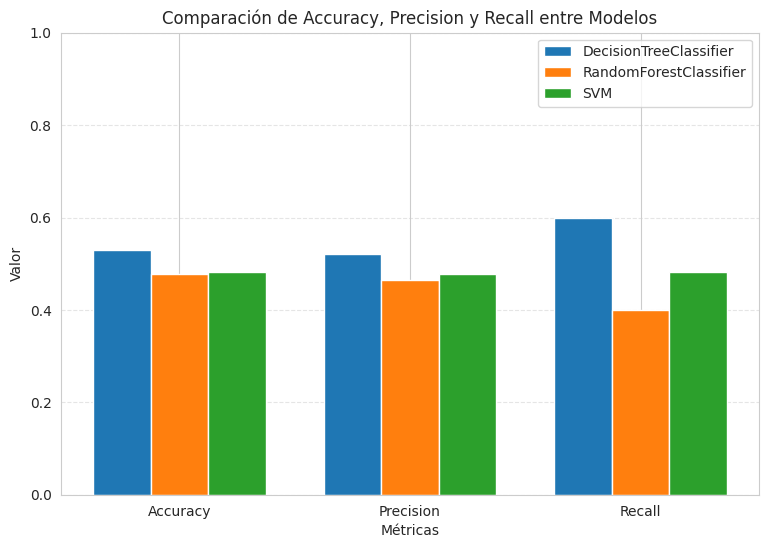

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall']
model1 = [accuracy1, precision1, recall1]
model2 = [accuracy2, precision2, recall2]
model3 = [accuracy3, precision3, recall3]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(9, 6))
plt.bar(x - width, model1, width, label='DecisionTreeClassifier')
plt.bar(x, model2, width, label='RandomForestClassifier')
plt.bar(x + width, model3, width, label='SVM')

plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.title('Comparación de Accuracy, Precision y Recall entre Modelos')
plt.xticks(x, metrics)
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


Primer punto

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

print("\n" + "="*80)
print("PUNTO 1: PCA + DNN (3 configuraciones de entrada)")
print("="*80)

# ------------------------------------------------------------
# 1. Train–Test Split (80/20) sobre el dataset de tu proyecto
#    X: imágenes aplanadas (n_samples, n_features)
#    y: etiqueta binaria de neumonía
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # X is already flattened (n_samples, 128*128)
    test_size=0.2,
    random_state=42,
    stratify=y
)

# The images are already flattened, so no need for x_dim, y_dim, channels calculations,
# nor for explicit reshaping of X_train/X_test as the split already returns flattened arrays.

print(f"\nTamaño X_train (flattened): {X_train.shape}")
print(f"Tamaño X_test (flattened) : {X_test.shape}")

n_features = X_train.shape[1] # This is the flattened number of features
# Fix: Ensure n_components is less than or equal to min(n_samples, n_features)
n_components = min(X_train.shape[0], n_features) // 2
print(f"\nNúmero de features originales (flattened) : {n_features}")
print(f"Número de componentes de PCA : {n_components} (≈ mitad de muestras o features)")

# ------------------------------------------------------------
# 2. PCA: reducción de dimensionalidad a la mitad (#features/2)
# ------------------------------------------------------------
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("\nPCA aplicado:")
print(f"  X_train_pca: {X_train_pca.shape}")
print(f"  X_test_pca : {X_test_pca.shape}")

# ------------------------------------------------------------
# 3. Concatenar features originales con las de PCA
#    X_concat = [Features; PCA_features]
# ------------------------------------------------------------
X_train_concat = np.hstack([X_train, X_train_pca])
X_test_concat  = np.hstack([X_test,  X_test_pca])

print("\nConcatenación [Features; PCA_features]:")
print(f"  X_train_concat: {X_train_concat.shape}")
print(f"  X_test_concat : {X_test_concat.shape}")

# ------------------------------------------------------------
# 4. Definir una DNN genérica para clasificación binaria
# ------------------------------------------------------------
def build_dnn(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

EPOCHS = 20
BATCH_SIZE = 16

resultados = {}

# ------------------------------------------------------------
# 5. MODELO A: solo Features originales
# ------------------------------------------------------------
print("\n" + "-"*70)
print("MODELO A: Solo features originales")
print("-"*70)

model_A = build_dnn(input_dim=n_features)

history_A = model_A.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

train_loss_A, train_acc_A, train_prec_A, train_rec_A = model_A.evaluate(
    X_train, y_train, verbose=0
)
test_loss_A, test_acc_A, test_prec_A, test_rec_A = model_A.evaluate(
    X_test, y_test, verbose=0
)

print("\nResultados MODELO A (Solo features originales):")
print(f"TRAIN -> loss: {train_loss_A:.4f}, acc: {train_acc_A:.4f}, "
      f"prec: {train_prec_A:.4f}, rec: {train_rec_A:.4f}")
print(f"TEST  -> loss: {test_loss_A:.4f}, acc: {test_acc_A:.4f}, "
      f"prec: {test_prec_A:.4f}, rec: {test_rec_A:.4f}")

resultados['A_solo_features'] = {
    'train': {'loss': train_loss_A, 'acc': train_acc_A,
              'prec': train_prec_A, 'rec': train_rec_A},
    'test':  {'loss': test_loss_A,  'acc': test_acc_A,
              'prec': test_prec_A,  'rec': test_rec_A}
}

# ------------------------------------------------------------
# 6. MODELO B: Features originales + PCA_features [X; X_pca]
# ------------------------------------------------------------
print("\n" + "-"*70)
print("MODELO B: Features originales + PCA_features")
print("-"*70)

model_B = build_dnn(input_dim=X_train_concat.shape[1])

history_B = model_B.fit(
    X_train_concat, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_concat, y_test),
    verbose=1
)

train_loss_B, train_acc_B, train_prec_B, train_rec_B = model_B.evaluate(
    X_train_concat, y_train, verbose=0
)
test_loss_B, test_acc_B, test_prec_B, test_rec_B = model_B.evaluate(
    X_test_concat, y_test, verbose=0
)

print("\nResultados MODELO B (Features + PCA_features):")
print(f"TRAIN -> loss: {train_loss_B:.4f}, acc: {train_acc_B:.4f}, "
      f"prec: {train_prec_B:.4f}, rec: {train_rec_B:.4f}")
print(f"TEST  -> loss: {test_loss_B:.4f}, acc: {test_acc_B:.4f}, "
      f"prec: {test_prec_B:.4f}, rec: {test_rec_B:.4f}")

resultados['B_features_mas_pca'] = {
    'train': {'loss': train_loss_B, 'acc': train_acc_B,
              'prec': train_prec_B, 'rec': train_rec_B},
    'test':  {'loss': test_loss_B,  'acc': test_acc_B,
              'prec': test_prec_B,  'rec': test_rec_B}
}

# ------------------------------------------------------------
# 7. MODELO C: Solo PCA_features
# ------------------------------------------------------------
print("\n" + "-"*70)
print("MODELO C: Solo PCA_features")
print("-"*70)

model_C = build_dnn(input_dim=n_components)

history_C = model_C.fit(
    X_train_pca, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_pca, y_test),
    verbose=1
)

train_loss_C, train_acc_C, train_prec_C, train_rec_C = model_C.evaluate(
    X_train_pca, y_train, verbose=0
)
test_loss_C, test_acc_C, test_prec_C, test_rec_C = model_C.evaluate(
    X_test_pca, y_test, verbose=0
)

print("\nResultados MODELO C (Solo PCA_features):")
print(f"TRAIN -> loss: {train_loss_C:.4f}, acc: {train_acc_C:.4f}, "
      f"prec: {train_prec_C:.4f}, rec: {train_rec_C:.4f}")
print(f"TEST  -> loss: {test_loss_C:.4f}, acc: {test_acc_C:.4f}, "
      f"prec: {test_prec_C:.4f}, rec: {test_rec_C:.4f}")

resultados['C_solo_pca'] = {
    'train': {'loss': train_loss_C, 'acc': train_acc_C,
              'prec': train_prec_C, 'rec': train_rec_C},
    'test':  {'loss': test_loss_C,  'acc': test_acc_C,
              'prec': test_prec_C,  'rec': test_rec_C}
}

print("\n" + "="*80)
print("RESUMEN COMPARATIVO (guardado en el dict 'resultados')")
print("="*80)
for nombre, res in resultados.items():
    print(f"\n>>> {nombre}")
    print("  TRAIN -> "
          f"loss: {res['train']['loss']:.4f}, "
          f"acc: {res['train']['acc']:.4f}, "
          f"prec: {res['train']['prec']:.4f}, "
          f"rec: {res['train']['rec']:.4f}")
    print("  TEST  -> "
          f"loss: {res['test']['loss']:.4f}, "
          f"acc: {res['test']['acc']:.4f}, "
          f"prec: {res['test']['prec']:.4f}, "
          f"rec: {res['test']['rec']:.4f}")


PUNTO 1: PCA + DNN (3 configuraciones de entrada)

Tamaño X_train (flattened): (688, 16384)
Tamaño X_test (flattened) : (172, 16384)

Número de features originales (flattened) : 16384
Número de componentes de PCA : 344 (≈ mitad de muestras o features)

PCA aplicado:
  X_train_pca: (688, 344)
  X_test_pca : (172, 344)

Concatenación [Features; PCA_features]:
  X_train_concat: (688, 16728)
  X_test_concat : (172, 16728)

----------------------------------------------------------------------
MODELO A: Solo features originales
----------------------------------------------------------------------
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4936 - loss: 0.9777 - precision: 0.4735 - recall: 0.4871 - val_accuracy: 0.5058 - val_loss: 2.2610 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5612 - loss: 0.7961 - precision: 0.5656 - recall: 0.5254 - val_accuracy: 0.5000 - val_loss: 0.7566 - val_precision: 0.4932 - v

segundo punto

Índices de las dos características más importantes: [ 6240 15788]
Importancias: [0.04549013 0.04463869]
Feature #1: índice 6240 -> pixel (fila=48, col=96)
Feature #2: índice 15788 -> pixel (fila=123, col=44)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Clusters KMeans (valores únicos): [0 1]
Clusters DBSCAN (valores únicos, -1 = ruido): [-1]


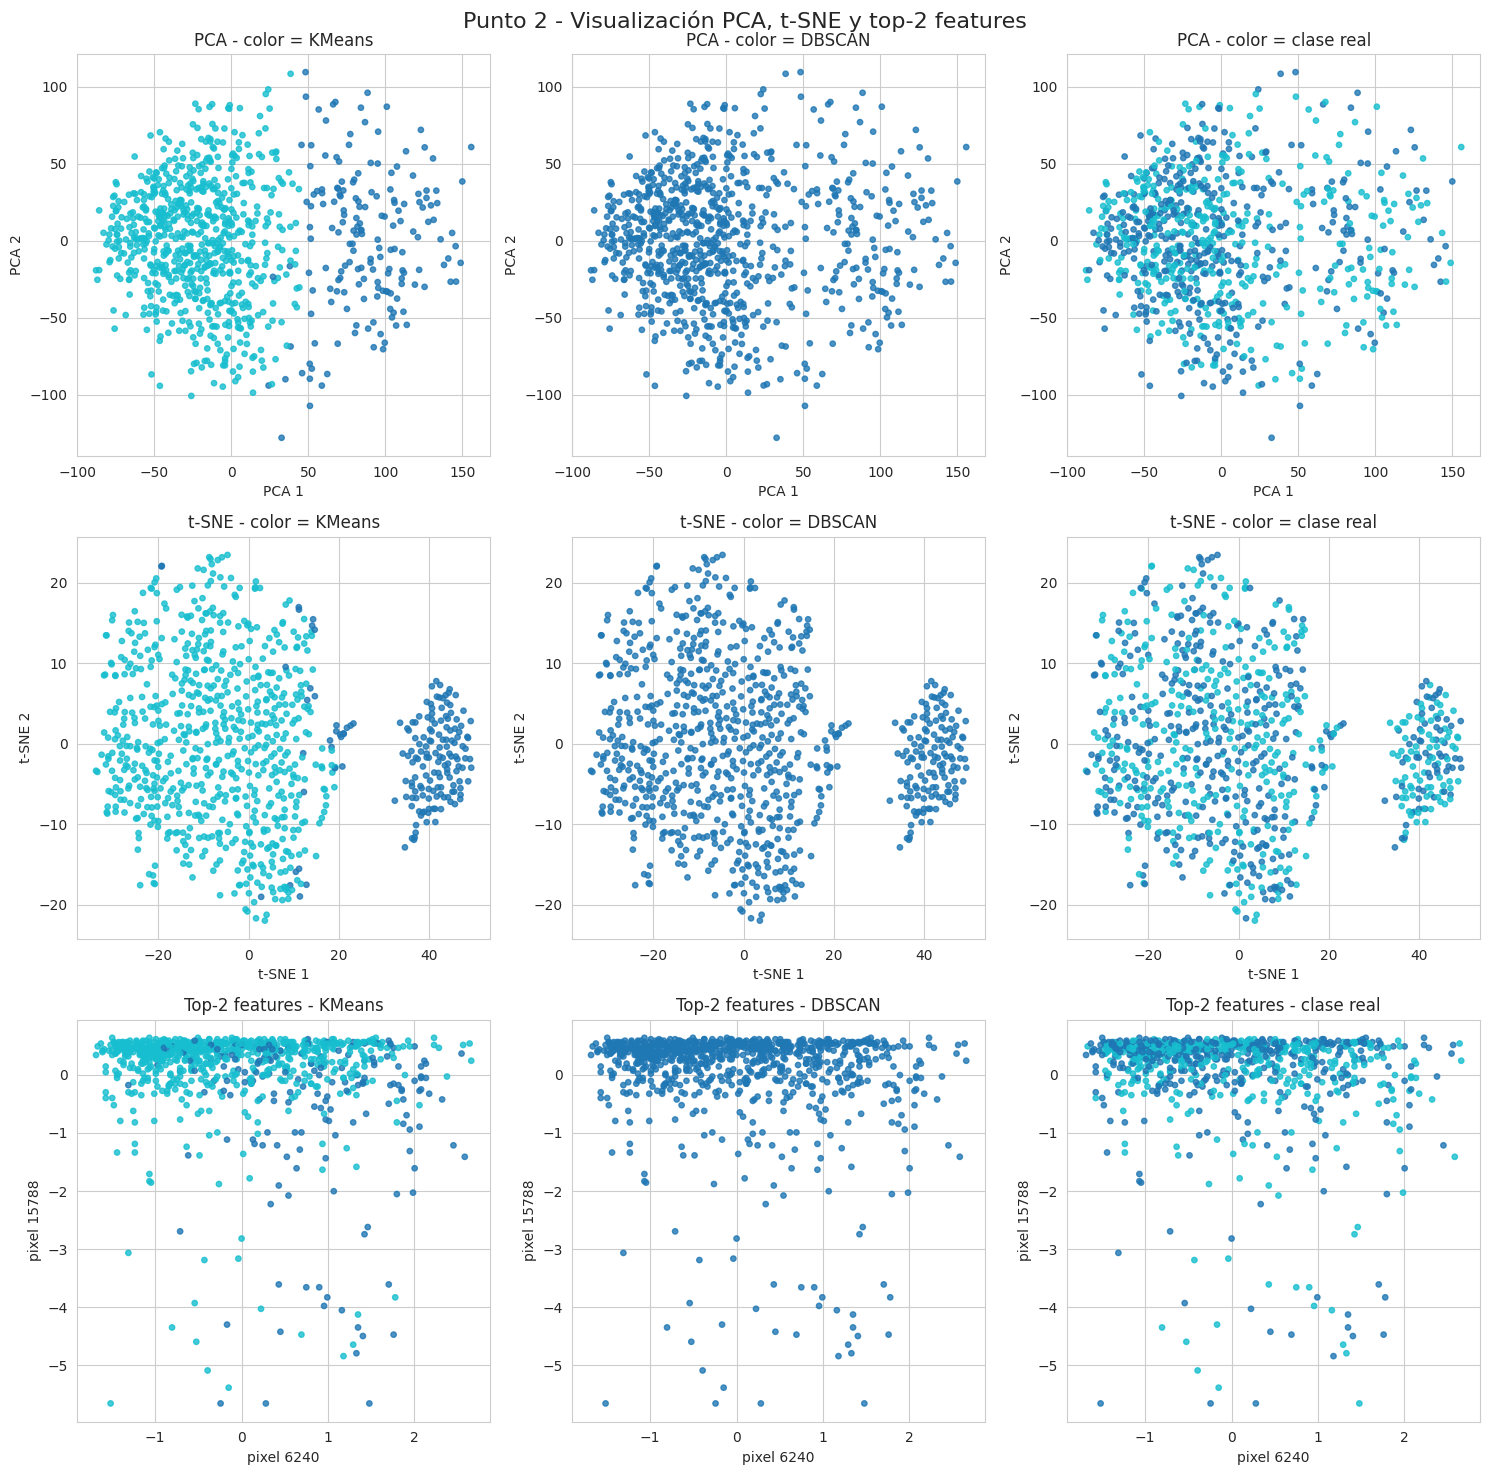

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

# ============================================================
# 0. Aplanar imágenes: X_flat tendrá las "características" originales (píxeles)
#    X tiene forma (n_muestras, 128, 128, 1) según tu notebook
# ============================================================
X_flat = X.reshape(X.shape[0], -1)   # (n_samples, 16384)

# ============================================================
# 1. Árbol de decisión con subconjunto de entrenamiento
#    y obtención de las 2 características más importantes
# ============================================================
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y
)

tree = DecisionTreeClassifier(
    max_depth=10,       # puedes ajustar la profundidad
    random_state=42
)
tree.fit(X_train_sub, y_train_sub)

importances = tree.feature_importances_          # vector (n_features,)
idx_sorted = np.argsort(importances)[::-1]       # índices ordenados
top2_idx = idx_sorted[:2]                        # dos más importantes

print("Índices de las dos características más importantes:", top2_idx)
print("Importancias:", importances[top2_idx])

# Opcional: convertir los índices a coordenadas (fila, columna) en la imagen 128x128
for rank, feat_idx in enumerate(top2_idx, start=1):
    fila, col = divmod(feat_idx, 128)
    print(f"Feature #{rank}: índice {feat_idx} -> pixel (fila={fila}, col={col})")

# ============================================================
# 2. Normalización + PCA(2) + t-SNE(2)
# ============================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)   # normalizamos las características originales

# PCA a 2 componentes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)       # (n_samples, 2)

# t-SNE a 2 componentes (puede tardar un poco)
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    learning_rate='auto',
    init='pca',
    random_state=42
)
X_tsne = tsne.fit_transform(X_scaled)     # (n_samples, 2)

# ============================================================
# 3. KMeans (K = #clases) y DBSCAN sobre características originales NORMALIZADAS
# ============================================================
n_classes = len(np.unique(y))

# KMeans
kmeans = KMeans(
    n_clusters=n_classes,
    n_init=10,
    random_state=42
)
labels_kmeans = kmeans.fit_predict(X_scaled)

# DBSCAN (ajusta eps/min_samples si ves todo en ruido o un solo cluster)
dbscan = DBSCAN(
    eps=2.0,         # PRUEBA con 1.5, 2.0, 3.0, etc.
    min_samples=5
)
labels_dbscan = dbscan.fit_predict(X_scaled)

print("Clusters KMeans (valores únicos):", np.unique(labels_kmeans))
print("Clusters DBSCAN (valores únicos, -1 = ruido):", np.unique(labels_dbscan))

# ============================================================
# 4. Construir matriz con las 2 mejores características del árbol
# ============================================================
X_best2 = X_scaled[:, top2_idx]   # usamos las mismas dos features del árbol

# ============================================================
# 5. Visualización 3x3
#    Fila 1: PCA (color KMeans, DBSCAN, clases)
#    Fila 2: t-SNE (color KMeans, DBSCAN, clases)
#    Fila 3: mejores 2 features (color KMeans, DBSCAN, clases)
# ============================================================

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Punto 2 - Visualización PCA, t-SNE y top-2 features", fontsize=16)

def scatter_panel(ax, x, y, labels, title, xlabel, ylabel):
    sc = ax.scatter(x, y, c=labels, cmap='tab10', s=15, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return sc

# --------- Fila 1: PCA ----------
# Colores: KMeans, DBSCAN, clases reales
scatter_panel(
    axes[0, 0],
    X_pca[:, 0], X_pca[:, 1],
    labels_kmeans,
    "PCA - color = KMeans",
    "PCA 1", "PCA 2"
)

scatter_panel(
    axes[0, 1],
    X_pca[:, 0], X_pca[:, 1],
    labels_dbscan,
    "PCA - color = DBSCAN",
    "PCA 1", "PCA 2"
)

scatter_panel(
    axes[0, 2],
    X_pca[:, 0], X_pca[:, 1],
    y,
    "PCA - color = clase real",
    "PCA 1", "PCA 2"
)

# --------- Fila 2: t-SNE ----------
scatter_panel(
    axes[1, 0],
    X_tsne[:, 0], X_tsne[:, 1],
    labels_kmeans,
    "t-SNE - color = KMeans",
    "t-SNE 1", "t-SNE 2"
)

scatter_panel(
    axes[1, 1],
    X_tsne[:, 0], X_tsne[:, 1],
    labels_dbscan,
    "t-SNE - color = DBSCAN",
    "t-SNE 1", "t-SNE 2"
)

scatter_panel(
    axes[1, 2],
    X_tsne[:, 0], X_tsne[:, 1],
    y,
    "t-SNE - color = clase real",
    "t-SNE 1", "t-SNE 2"
)

# --------- Fila 3: mejores 2 características del árbol ----------
feat1_idx, feat2_idx = top2_idx
feat1_name = f"pixel {feat1_idx}"
feat2_name = f"pixel {feat2_idx}"

scatter_panel(
    axes[2, 0],
    X_best2[:, 0], X_best2[:, 1],
    labels_kmeans,
    "Top-2 features - KMeans",
    feat1_name, feat2_name
)

scatter_panel(
    axes[2, 1],
    X_best2[:, 0], X_best2[:, 1],
    labels_dbscan,
    "Top-2 features - DBSCAN",
    feat1_name, feat2_name
)

scatter_panel(
    axes[2, 2],
    X_best2[:, 0], X_best2[:, 1],
    y,
    "Top-2 features - clase real",
    feat1_name, feat2_name
)

plt.tight_layout()
plt.show()


#termino

APLICANDO MÉTODOS DE CLUSTERING NO SUPERVISADO

📊 Normalizando datos para clustering...
Datos normalizados: (860, 16384)

K-MEANS CLUSTERING
Centros de clusters encontrados: (2, 16384)
Labels asignados: (860,)

Distribución de clusters:
  Cluster 0: 685 muestras (79.7%)
  Cluster 1: 175 muestras (20.3%)

🔍 Aplicando método del codo para encontrar K óptimo...


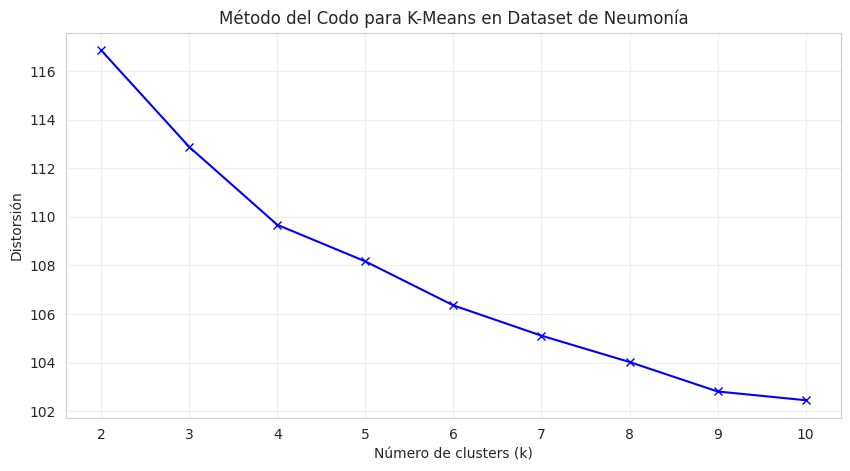


DBSCAN CLUSTERING
Labels asignados: (860,)

Distribución de clusters (incluyendo ruido -1):
  Ruido: 860 muestras (100.0%)

HIERARCHICAL CLUSTERING (AGGLOMERATIVE)
Labels asignados: (860,)

Distribución de clusters:
  Cluster 0: 727 muestras (84.5%)
  Cluster 1: 133 muestras (15.5%)

📊 Creando dendrograma (muestra de 100 imágenes)...


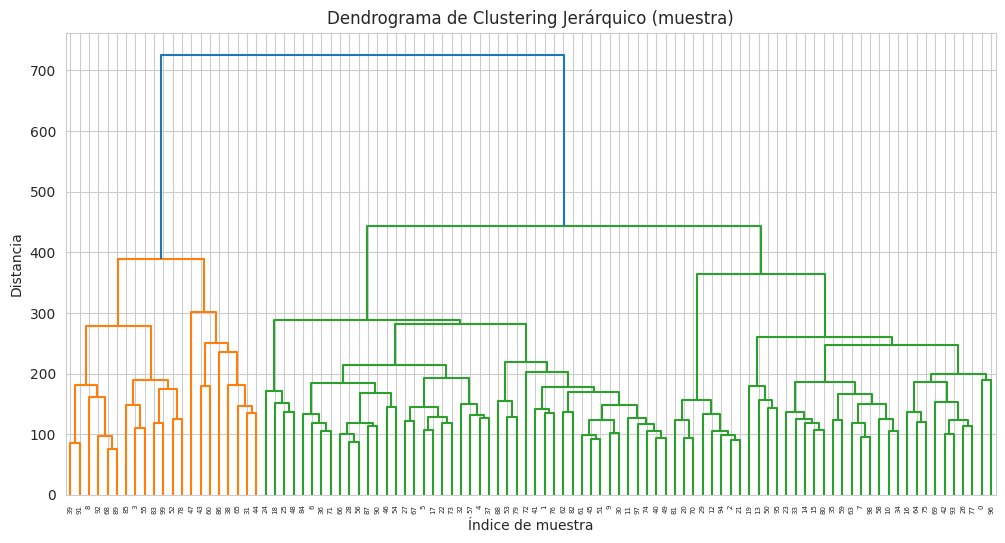


COMPARACIÓN DE MÉTODOS DE CLUSTERING


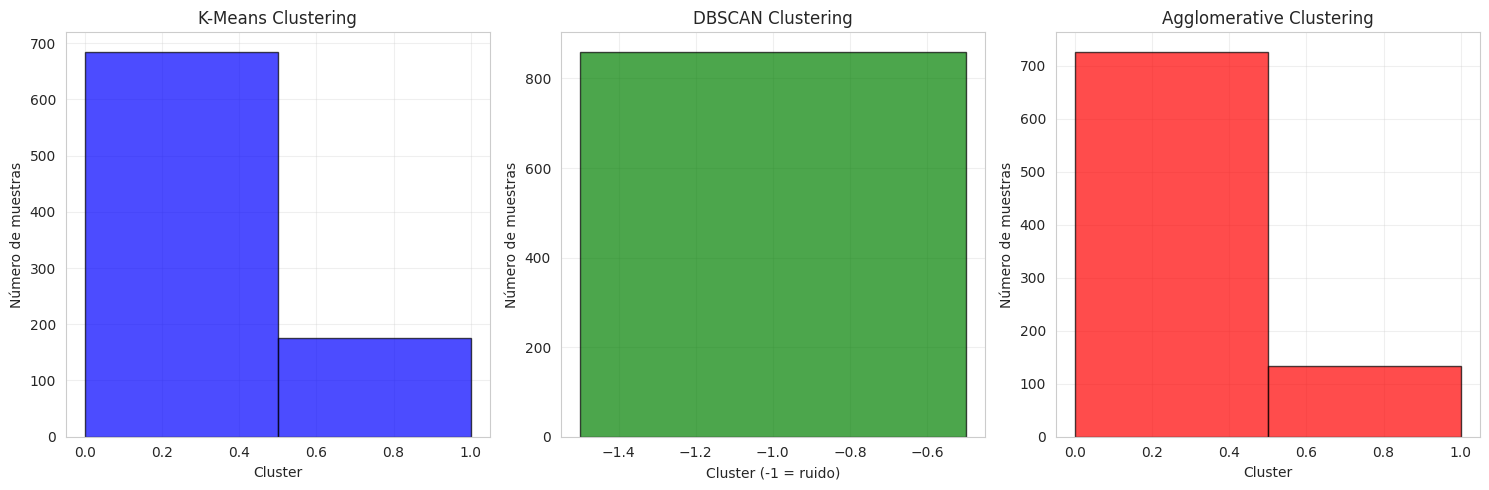


✓ Clustering no supervisado completado
APLICANDO MÉTODOS DE REDUCCIÓN DIMENSIONAL

PCA - ANÁLISIS DE COMPONENTES PRINCIPALES

📊 Aplicando PCA con 2 componentes...
Forma original: (860, 16384)
Forma después de PCA (2 componentes): (860, 2)

Varianza explicada por cada componente:
  PC 1: 18.51%
  PC 2: 10.71%
Varianza total explicada: 29.22%


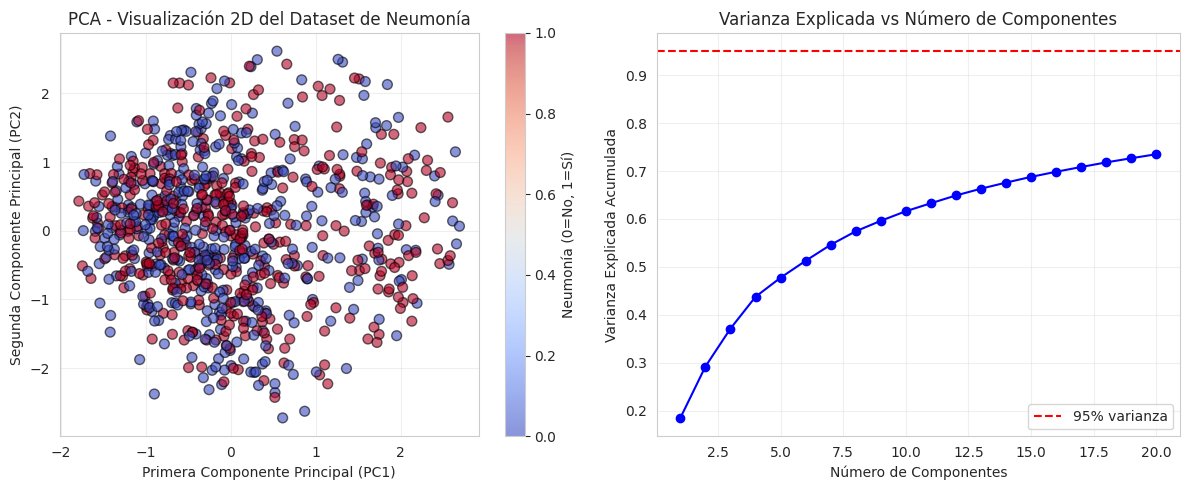


📊 Aplicando PCA con 3 componentes...
Forma después de PCA (3 componentes): (860, 3)

Varianza explicada por cada componente:
  PC 1: 18.51%
  PC 2: 10.71%
  PC 3: 7.91%
Varianza total explicada: 37.13%


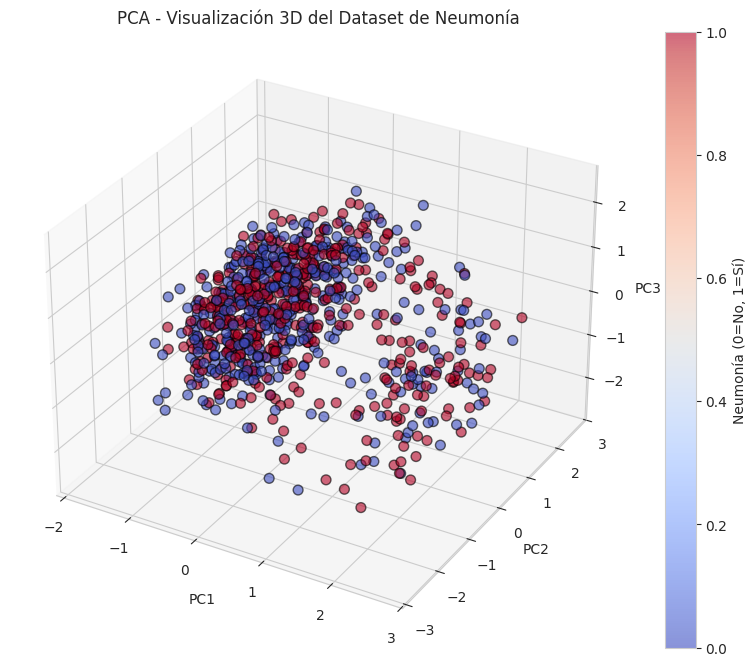


CLASIFICACIÓN USANDO COMPONENTES PRINCIPALES

Comparando accuracy con diferentes números de componentes PCA:
  2 componentes -> Accuracy: 0.500, Precision: 0.489, Recall: 0.259
  5 componentes -> Accuracy: 0.494, Precision: 0.486, Recall: 0.400
  10 componentes -> Accuracy: 0.541, Precision: 0.528, Recall: 0.659
  20 componentes -> Accuracy: 0.506, Precision: 0.500, Recall: 0.565
  50 componentes -> Accuracy: 0.436, Precision: 0.429, Recall: 0.424


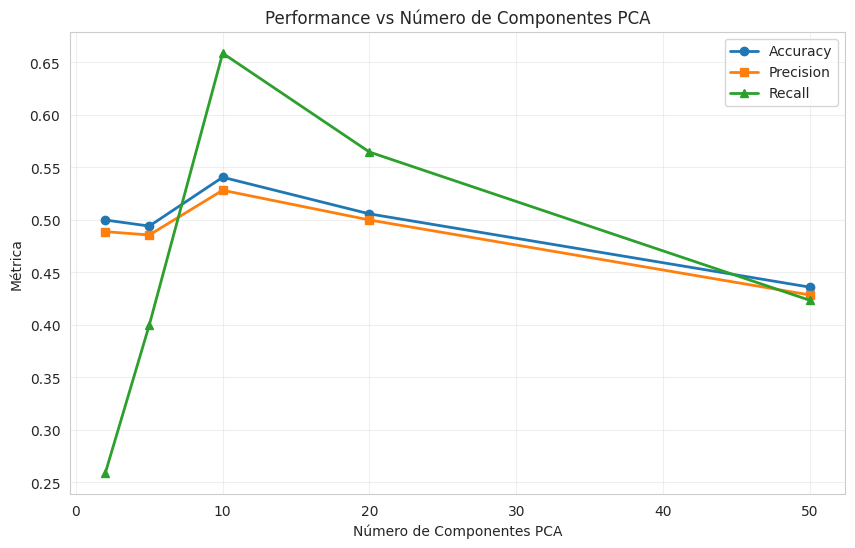


T-SNE - EMBEDDINGS ESTOCÁSTICOS

📊 Aplicando t-SNE con 2 componentes...
⚠ Nota: t-SNE puede tardar varios minutos en datasets grandes...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Forma original: (860, 16384)
Forma después de t-SNE (2 componentes): (860, 2)

COMPARACIÓN: PCA vs t-SNE


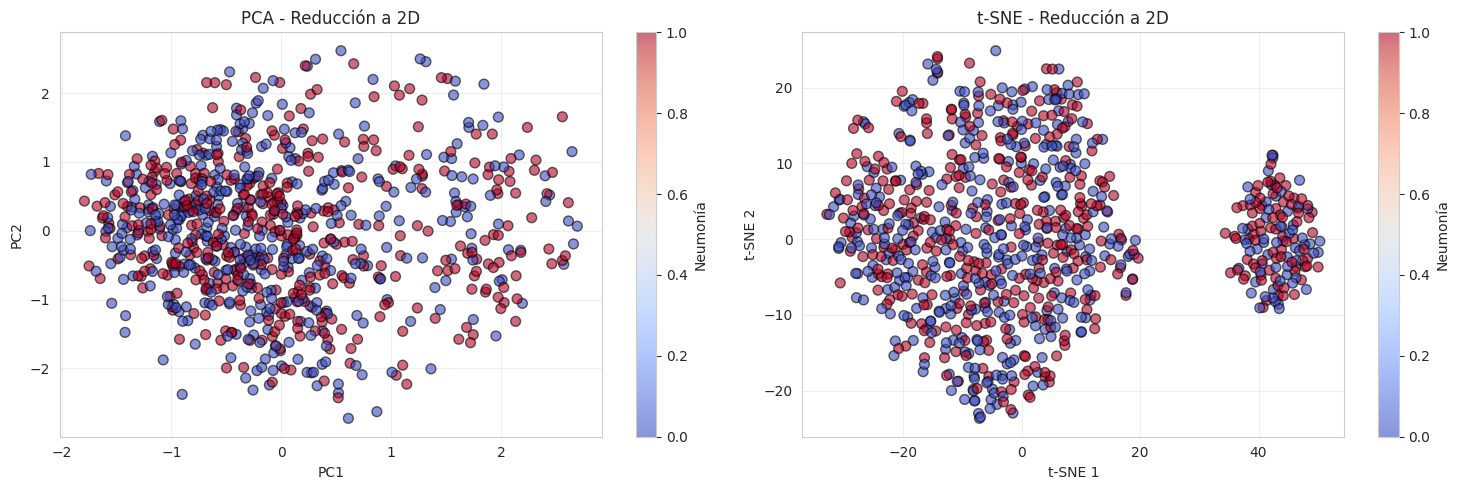


✓ Reducción dimensional completada

RESUMEN DE REDUCCIÓN DIMENSIONAL

Dimensionalidad original: 16384 features

PCA (2 componentes):
  - Nueva dimensionalidad: 2 features
  - Varianza explicada: 29.22%

t-SNE (2 componentes):
  - Nueva dimensionalidad: 2 features
  - Mejor para visualización de estructura local

TODOS LOS ANÁLISIS NO SUPERVISADOS COMPLETADOS

✓ Clustering: K-Means, DBSCAN, Agglomerative
✓ Reducción Dimensional: PCA, t-SNE

Ahora puedes continuar con el resto de tu proyecto.


In [ ]:

"""
#===============================================================================
# NON-SUPERVISED LEARNING (CLUSTERING)
"""

# Imports necesarios para clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

print("="*80)
print("APLICANDO MÉTODOS DE CLUSTERING NO SUPERVISADO")
print("="*80)

# ============================================
# 1. PREPARAR DATOS PARA CLUSTERING
# ============================================
# Usaremos las imágenes ya cargadas y aplanadas (X) sin las etiquetas (y)
# Para clustering, vamos a normalizar los datos

print("\n📊 Normalizando datos para clustering...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Datos normalizados: {X_scaled.shape}")

# ============================================
# 2. K-MEANS CLUSTERING
# ============================================
print("\n" + "="*60)
print("K-MEANS CLUSTERING")
print("="*60)

# Aplicar K-Means con k=2 (ya que sabemos que hay 2 clases: con y sin neumonía)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

print(f"Centros de clusters encontrados: {kmeans.cluster_centers_.shape}")
print(f"Labels asignados: {kmeans_labels.shape}")
print(f"\nDistribución de clusters:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} muestras ({count/len(kmeans_labels)*100:.1f}%)")

# Método del codo (Elbow Method) para encontrar el K óptimo
print("\n🔍 Aplicando método del codo para encontrar K óptimo...")
distortions = []
K_range = range(2, 11)
for k in K_range:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(X_scaled)
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])

plt.figure(figsize=(10, 5))
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Distorsión')
plt.title('Método del Codo para K-Means en Dataset de Neumonía')
plt.grid(alpha=0.3)
plt.show()

# ============================================
# 3. DBSCAN CLUSTERING
# ============================================
print("\n" + "="*60)
print("DBSCAN CLUSTERING")
print("="*60)

# Aplicar DBSCAN (clustering basado en densidad)
# Nota: eps debe ajustarse según los datos
dbs = DBSCAN(eps=50, min_samples=5)
dbscan_labels = dbs.fit_predict(X_scaled)

print(f"Labels asignados: {dbscan_labels.shape}")
print(f"\nDistribución de clusters (incluyendo ruido -1):")
unique_dbs, counts_dbs = np.unique(dbscan_labels, return_counts=True)
for cluster, count in zip(unique_dbs, counts_dbs):
    if cluster == -1:
        print(f"  Ruido: {count} muestras ({count/len(dbscan_labels)*100:.1f}%)")
    else:
        print(f"  Cluster {cluster}: {count} muestras ({count/len(dbscan_labels)*100:.1f}%)")

# ============================================
# 4. HIERARCHICAL CLUSTERING (AGGLOMERATIVE)
# ============================================
print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING (AGGLOMERATIVE)")
print("="*60)

# Aplicar clustering jerárquico aglomerativo
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

print(f"Labels asignados: {agg_labels.shape}")
print(f"\nDistribución de clusters:")
unique_agg, counts_agg = np.unique(agg_labels, return_counts=True)
for cluster, count in zip(unique_agg, counts_agg):
    print(f"  Cluster {cluster}: {count} muestras ({count/len(agg_labels)*100:.1f}%)")

# Crear dendrograma (solo con una muestra pequeña para visualización)
print("\n📊 Creando dendrograma (muestra de 100 imágenes)...")
sample_indices = np.random.choice(len(X_scaled), size=min(100, len(X_scaled)), replace=False)
X_sample = X_scaled[sample_indices]
clusters_sample = hierarchy.linkage(X_sample, method='ward')

plt.figure(figsize=(12, 6))
dendrogram = hierarchy.dendrogram(clusters_sample)
plt.title('Dendrograma de Clustering Jerárquico (muestra)')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia')
plt.show()

# ============================================
# 5. COMPARACIÓN DE RESULTADOS
# ============================================
print("\n" + "="*60)
print("COMPARACIÓN DE MÉTODOS DE CLUSTERING")
print("="*60)

# Visualizar comparación de los tres métodos
plt.figure(figsize=(15, 5))

# K-Means
plt.subplot(131)
plt.hist(kmeans_labels, bins=len(np.unique(kmeans_labels)), alpha=0.7, color='blue', edgecolor='black')
plt.title('K-Means Clustering')
plt.xlabel('Cluster')
plt.ylabel('Número de muestras')
plt.grid(alpha=0.3)

# DBSCAN
plt.subplot(132)
plt.hist(dbscan_labels, bins=len(np.unique(dbscan_labels)), alpha=0.7, color='green', edgecolor='black')
plt.title('DBSCAN Clustering')
plt.xlabel('Cluster (-1 = ruido)')
plt.ylabel('Número de muestras')
plt.grid(alpha=0.3)

# Agglomerative
plt.subplot(133)
plt.hist(agg_labels, bins=len(np.unique(agg_labels)), alpha=0.7, color='red', edgecolor='black')
plt.title('Agglomerative Clustering')
plt.xlabel('Cluster')
plt.ylabel('Número de muestras')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Clustering no supervisado completado")



"""
#===============================================================================
# DIMENSIONAL REDUCTION
# Basado en el notebook 15_std_notes_dimensional_reduction.py
#===============================================================================
"""

# Imports necesarios para reducción dimensional
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("="*80)
print("APLICANDO MÉTODOS DE REDUCCIÓN DIMENSIONAL")
print("="*80)

# ============================================
# 1. PCA - PRINCIPAL COMPONENT ANALYSIS
# ============================================
print("\n" + "="*60)
print("PCA - ANÁLISIS DE COMPONENTES PRINCIPALES")
print("="*60)

# Aplicar PCA para reducir dimensionalidad a 2 componentes
print("\n📊 Aplicando PCA con 2 componentes...")
pca_2 = PCA(n_components=2, whiten=True, random_state=42)
X_pca_2 = pca_2.fit_transform(X)

print(f"Forma original: {X.shape}")
print(f"Forma después de PCA (2 componentes): {X_pca_2.shape}")
print(f"\nVarianza explicada por cada componente:")
for i, var in enumerate(pca_2.explained_variance_ratio_, 1):
    print(f"  PC {i}: {var*100:.2f}%")
print(f"Varianza total explicada: {pca_2.explained_variance_ratio_.sum()*100:.2f}%")

# Visualizar datos reducidos con PCA (2D)
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', s=50)
plt.xlabel('Primera Componente Principal (PC1)')
plt.ylabel('Segunda Componente Principal (PC2)')
plt.title('PCA - Visualización 2D del Dataset de Neumonía')
plt.colorbar(label='Neumonía (0=No, 1=Sí)')
plt.grid(alpha=0.3)

# Gráfico de varianza explicada acumulada
plt.subplot(122)
# Calcular para más componentes para ver el patrón
pca_full = PCA(random_state=42)
pca_full.fit(X)
variance_ratio = pca_full.explained_variance_ratio_[:20]  # Primeros 20 componentes
cumsum_variance = np.cumsum(variance_ratio)

plt.plot(range(1, len(variance_ratio)+1), cumsum_variance, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada vs Número de Componentes')
plt.grid(alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.legend()

plt.tight_layout()
plt.show()

# PCA con 3 componentes para visualización 3D
print("\n📊 Aplicando PCA con 3 componentes...")
pca_3 = PCA(n_components=3, whiten=True, random_state=42)
X_pca_3 = pca_3.fit_transform(X)

print(f"Forma después de PCA (3 componentes): {X_pca_3.shape}")
print(f"\nVarianza explicada por cada componente:")
for i, var in enumerate(pca_3.explained_variance_ratio_, 1):
    print(f"  PC {i}: {var*100:.2f}%")
print(f"Varianza total explicada: {pca_3.explained_variance_ratio_.sum()*100:.2f}%")

# Visualización 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter3D(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2],
                       c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Visualización 3D del Dataset de Neumonía')
plt.colorbar(scatter, label='Neumonía (0=No, 1=Sí)')
plt.show()

# ============================================
# 2. CLASIFICACIÓN CON COMPONENTES REDUCIDOS
# ============================================
print("\n" + "="*60)
print("CLASIFICACIÓN USANDO COMPONENTES PRINCIPALES")
print("="*60)

# Probar clasificación con diferentes números de componentes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score

components_to_test = [2, 5, 10, 20, 50]
results_pca = []

print("\nComparando accuracy con diferentes números de componentes PCA:")
for n_comp in components_to_test:
    if n_comp > X.shape[1]:
        continue

    # Aplicar PCA
    pca_temp = PCA(n_components=n_comp, whiten=True, random_state=42)
    X_pca_temp = pca_temp.fit_transform(X)

    # Dividir en train/test
    from sklearn.model_selection import train_test_split
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
        X_pca_temp, y, test_size=0.2, random_state=42, stratify=y
    )

    # Entrenar y evaluar
    gnb = GaussianNB()
    gnb.fit(X_train_pca, y_train_pca)
    y_pred_pca = gnb.predict(X_test_pca)

    acc = accuracy_score(y_test_pca, y_pred_pca)
    prec = precision_score(y_test_pca, y_pred_pca)
    rec = recall_score(y_test_pca, y_pred_pca)

    results_pca.append((n_comp, acc, prec, rec))
    print(f"  {n_comp} componentes -> Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

# Visualizar resultados
if results_pca:
    components, accuracies, precisions, recalls = zip(*results_pca)

    plt.figure(figsize=(10, 6))
    plt.plot(components, accuracies, 'o-', label='Accuracy', linewidth=2)
    plt.plot(components, precisions, 's-', label='Precision', linewidth=2)
    plt.plot(components, recalls, '^-', label='Recall', linewidth=2)
    plt.xlabel('Número de Componentes PCA')
    plt.ylabel('Métrica')
    plt.title('Performance vs Número de Componentes PCA')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# ============================================
# 3. T-SNE - T-DISTRIBUTED STOCHASTIC NEIGHBOR EMBEDDING
# ============================================
print("\n" + "="*60)
print("T-SNE - EMBEDDINGS ESTOCÁSTICOS")
print("="*60)

# Aplicar t-SNE con 2 componentes
print("\n📊 Aplicando t-SNE con 2 componentes...")
print("⚠ Nota: t-SNE puede tardar varios minutos en datasets grandes...")

tsne_2 = TSNE(n_components=2, learning_rate='auto', random_state=42,
              perplexity=30, n_iter=1000)
X_tsne_2 = tsne_2.fit_transform(X)

print(f"Forma original: {X.shape}")
print(f"Forma después de t-SNE (2 componentes): {X_tsne_2.shape}")

# ============================================
# 4. COMPARACIÓN PCA vs t-SNE
# ============================================
print("\n" + "="*60)
print("COMPARACIÓN: PCA vs t-SNE")
print("="*60)

plt.figure(figsize=(15, 5))

# Visualización con PCA
plt.subplot(121)
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Reducción a 2D')
plt.colorbar(label='Neumonía')
plt.grid(alpha=0.3)

# Visualización con t-SNE
plt.subplot(122)
plt.scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE - Reducción a 2D')
plt.colorbar(label='Neumonía')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Reducción dimensional completada")

# ============================================
# 5. RESUMEN DE REDUCCIÓN DIMENSIONAL
# ============================================
print("\n" + "="*60)
print("RESUMEN DE REDUCCIÓN DIMENSIONAL")
print("="*60)
print(f"\nDimensionalidad original: {X.shape[1]} features")
print(f"\nPCA (2 componentes):")
print(f"  - Nueva dimensionalidad: {X_pca_2.shape[1]} features")
print(f"  - Varianza explicada: {pca_2.explained_variance_ratio_.sum()*100:.2f}%")
print(f"\nt-SNE (2 componentes):")
print(f"  - Nueva dimensionalidad: {X_tsne_2.shape[1]} features")
print(f"  - Mejor para visualización de estructura local")


"""
#===============================================================================
# FIN DEL CÓDIGO AGREGADO
#===============================================================================
"""

print("\n" + "="*80)
print("TODOS LOS ANÁLISIS NO SUPERVISADOS COMPLETADOS")
print("="*80)
print("\n✓ Clustering: K-Means, DBSCAN, Agglomerative")
print("✓ Reducción Dimensional: PCA, t-SNE")
print("\nAhora puedes continuar con el resto de tu proyecto.")


#Distribución de neumonía por sexo

Pregunta: ¿quién tiene más casos de neumonía, hombres o mujeres?

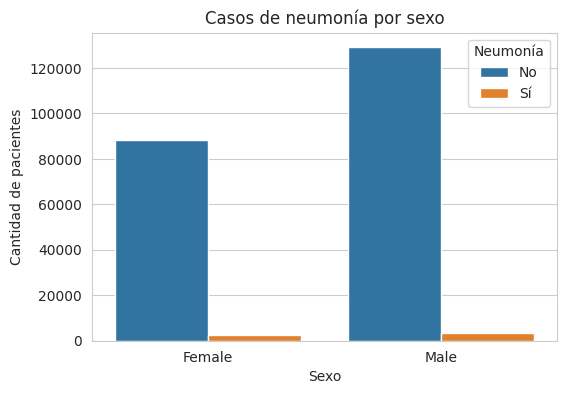

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Sex", hue="Pneumonia")
plt.title("Casos de neumonía por sexo")
plt.xlabel("Sexo")
plt.ylabel("Cantidad de pacientes")
plt.legend(title="Neumonía", labels=["No", "Sí"])
plt.show()

#Porcentaje de neumonía por sexo (no solo el conteo)

Sex
Female    2.734173
Male      2.681776
Name: Pneumonia, dtype: float64


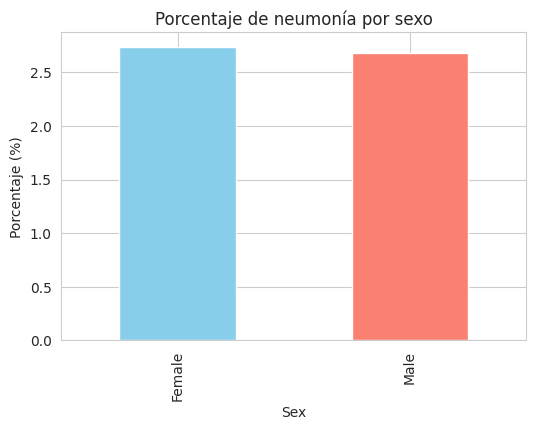

In [ ]:
# Reemplazar Unknown y NaN en la columna Sex
df["Sex"] = df["Sex"].replace("Unknown", pd.NA)
df = df.dropna(subset=["Sex"])  # elimina filas sin sexo

# Gráfico corregido
pneumonia_by_sex = df.groupby("Sex")["Pneumonia"].mean() * 100
print(pneumonia_by_sex)

pneumonia_by_sex.plot(kind="bar", color=["skyblue", "salmon"], figsize=(6,4))
plt.title("Porcentaje de neumonía por sexo")
plt.ylabel("Porcentaje (%)")
plt.show()

#Distribución de edades en pacientes con neumonía

Pregunta: ¿en qué edades es más común?

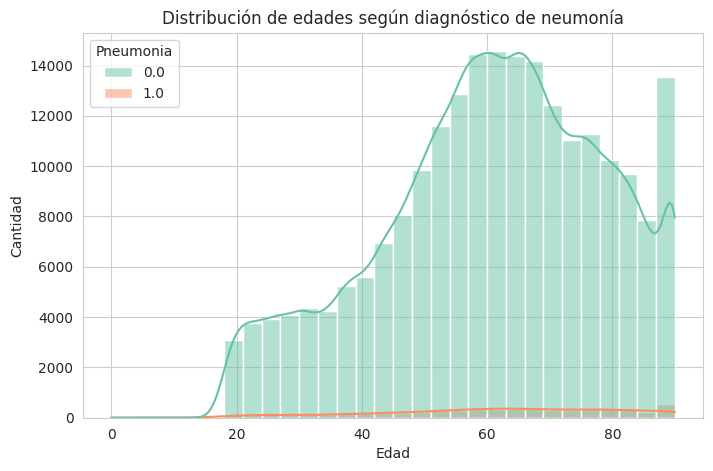

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="Age", hue="Pneumonia", bins=30, kde=True, palette="Set2")
plt.title("Distribución de edades según diagnóstico de neumonía")
plt.xlabel("Edad")
plt.ylabel("Cantidad")
plt.show()